In [1]:
from evaluation_model import evaluate
from train_model import trainer
import os

import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from pytorch_helper import BoundaryNetwork
from analytic_model import analytic_solution

In [2]:
# trainer('LAZ',10,5e-4)

In [3]:
# evaluate('LAZ',1,10,5e-4)

In [4]:
# stock_names = []
# versions = []
# betas = []

# folder_path = "../beta"
# files = os.listdir(folder_path)
# for file in files:
#     f= file.split('.')[0]
#     file_path = f'models/{f}_lower_model_1.pth'
#     # print(file_path)
#     if not os.path.exists(file_path):
#         trainer(f,1,5e-4)
#         evaluate(f,1,1,5e-4)

In [2]:
ticker = 'LAZ'
# cost_rates = [1e-4,5e-4,1e-3,5e-3,1e-2]
cost_rates = [0.018,0.022,0.026,0.03]

end_year =2020

results = {}
model_version = 17
# # trainer(ticker,0,0.03,'_linear')
for rate in cost_rates:
    # trainer(ticker,model_version,rate,note=f'_{rate}', attempts=10)
    trainer(ticker,rate,rate,'_linear',attempts=2)

Processing : LAZ
Training Model [1/2]
Epoch [0/2000], Loss: 0.0007964755, LR: 0.000100, Average Wealth: 1254.0, Average total costs paid: 203.0
Epoch [100/2000], Loss: 0.0007939501, LR: 0.000100, Average Wealth: 1260.0, Average total costs paid: 119.0
Epoch [200/2000], Loss: 0.0008127578, LR: 0.000050, Average Wealth: 1230.0, Average total costs paid: 37.0
Epoch [300/2000], Loss: 0.0008153156, LR: 0.000050, Average Wealth: 1227.0, Average total costs paid: 101.0
Epoch [400/2000], Loss: 0.0008091619, LR: 0.000025, Average Wealth: 1238.0, Average total costs paid: 178.0
Epoch [500/2000], Loss: 0.0008077279, LR: 0.000025, Average Wealth: 1240.0, Average total costs paid: 173.0
Epoch [600/2000], Loss: 0.0008157985, LR: 0.000013, Average Wealth: 1226.0, Average total costs paid: 110.0
Epoch [700/2000], Loss: 0.0008161298, LR: 0.000013, Average Wealth: 1226.0, Average total costs paid: 108.0
Epoch [800/2000], Loss: 0.0008147147, LR: 0.000006, Average Wealth: 1228.0, Average total costs paid:

In [11]:
ticker = 'LAZ'
model_version = 17
alpha = 1e-2
# trainer(ticker,model_version,alpha, attempts=10, note=f'_{alpha}')
# trainer(ticker,0,0.03,'_linear',attempts=5)
evaluate(ticker,model_version,3,alpha,note=f'_{alpha}')

Evaluating model: 17 for LAZ, run number: 3
Final wealth of trained model: 1133.0143660459644
Final wealth of base model: 3.4758634221752813
Final wealth of linear trained model: 173.25648619609888


In [ ]:
ticker = 'LAZ'
model_version = 14
alpha = 1e-4
# trainer(ticker,model_version,alpha)
trainer(ticker,0,0.03,'_linear')
evaluate(ticker,model_version,2,alpha)

In [11]:
ticker = 'LAZ'
end_year =2020
hidden_dim = 64
input_dim = 4
results = {}
model_version = 3
coeffs = json.load(open(f"model_asset_coefficients/{ticker}_coeffs_endyear_{end_year}.json"))
lam, mu, sigma = coeffs['lambda'], coeffs['mu'], coeffs['sigma']
ra, r = 2, 0.05

cost_rates = [0.018,0.022,0.026,0.03]
analytic_model = analytic_solution(ra, r, lam, mu, sigma)
x1 =np.linspace(28,32,1000)
results['x'] = x1.tolist()
x = torch.from_numpy(x1).float().unsqueeze(1).to('cuda')
wealth = torch.ones((1000, 1), device='cuda') * 1000
t = 1
time_left = torch.ones_like(x).to('cuda') * t
pi_minus = torch.ones_like(x).to('cuda') * 0
inputs = torch.cat([x, wealth, pi_minus,time_left], dim=1)
no_cost_position = np.clip(analytic_model.optimal_nocost((t), x1), -1.0, 1.0).reshape(1000, 1)
results['no cost'] = no_cost_position.tolist()
for rate in cost_rates:
    upper_model = BoundaryNetwork(input_dim, hidden_dim).to('cuda')
    # upper_model.load_state_dict(torch.load(f"models/{ticker}_upper_model_{model_version}_{rate}.pth", weights_only=True))
    upper_model.load_state_dict(torch.load(f"models/{ticker}_upper_model_{rate}_linear.pth", weights_only=True))

    # upper_model.load_state_dict(torch.load(f"models/{ticker}_upper_model_{model_version}.pth", weights_only=True))

    upper_model.eval()
    
    lower_model = BoundaryNetwork(input_dim, hidden_dim).to('cuda')
    # lower_model.load_state_dict(torch.load(f"models/{ticker}_lower_model_{model_version}_{rate}.pth", weights_only=True))
    lower_model.load_state_dict(torch.load(f"models/{ticker}_lower_model_{rate}_linear.pth", weights_only=True))

    # lower_model.load_state_dict(torch.load(f"models/{ticker}_lower_model_{model_version}.pth", weights_only=True))

    lower_model.eval()
    
    upper_offset = upper_model(inputs).detach().cpu().numpy()
    lower_offset = lower_model(inputs).detach().cpu().numpy()
    upper_boundary = np.clip(no_cost_position + upper_offset, -1.0, 1.0)
    lower_boundary = np.clip(no_cost_position - lower_offset, -1.0, 1.0)
    results[f'lower_{rate}'] = lower_boundary.tolist()
    results[f'upper_{rate}'] = upper_boundary.tolist()
file_path = 'cost_data.json'
json.dump(results, open(file_path, "w"))

Text(0, 0.5, 'Proportion of Wealth in Risky Asset')

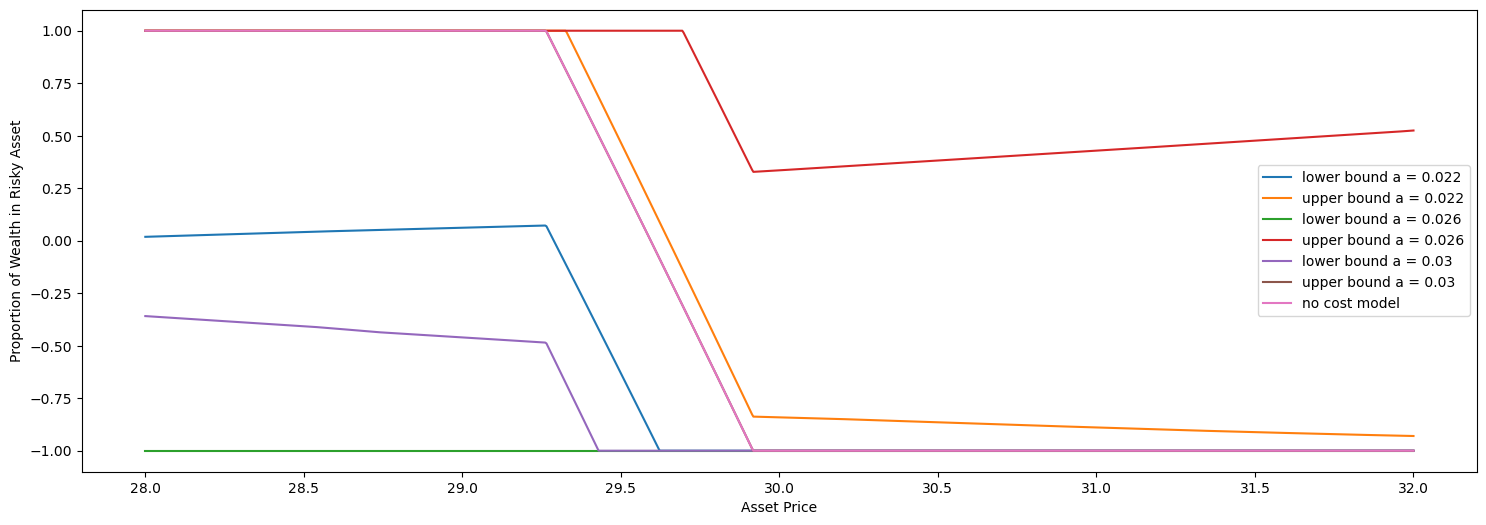

In [13]:
cost_rates = [0.022,0.026,0.03]
plt.figure(figsize=(18, 6))
for rate in cost_rates:
    plt.plot(results['x'],results[f'lower_{rate}'],label=f'lower bound a = {rate}')
    plt.plot(results['x'],results[f'upper_{rate}'],label=f'upper bound a = {rate}')
plt.plot(results['x'],results['no cost'],label='no cost model')
plt.legend()
plt.xlabel('Asset Price')
plt.ylabel('Proportion of Wealth in Risky Asset')


Text(0.5, 0, 'Asset Price')

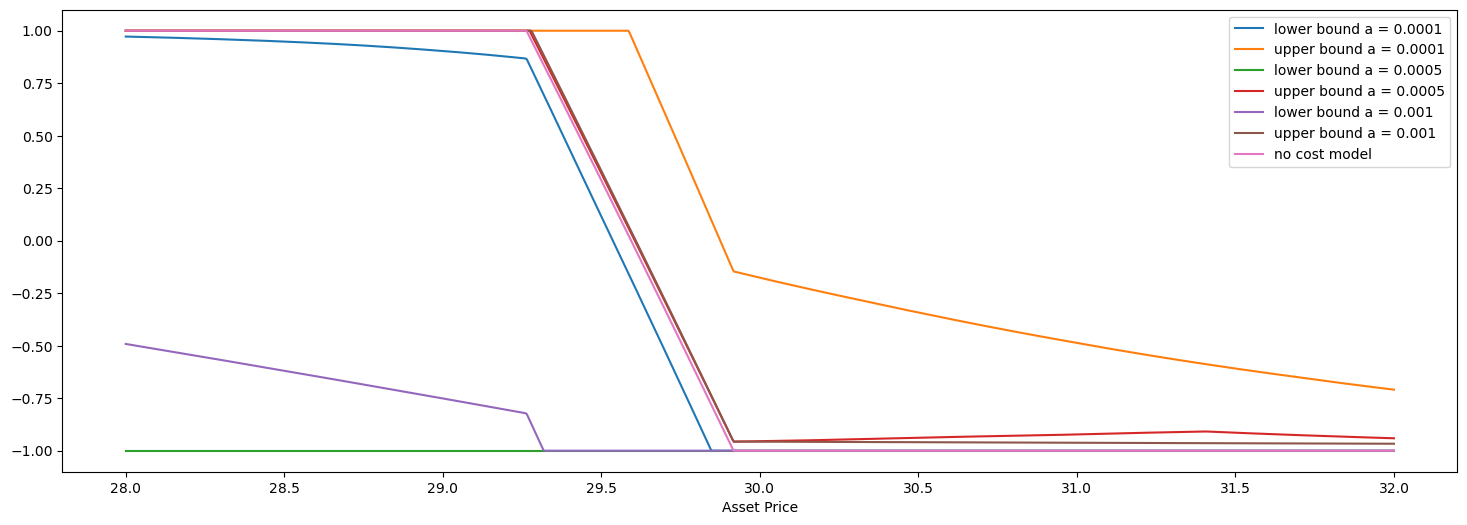

In [12]:
cost_rates = [1e-4,5e-4,1e-3]
plt.figure(figsize=(18, 6))
for rate in cost_rates:
    plt.plot(results['x'],results[f'lower_{rate}'],label=f'lower bound a = {rate}')
    plt.plot(results['x'],results[f'upper_{rate}'],label=f'upper bound a = {rate}')
plt.plot(results['x'],results['no cost'],label='no cost model')
plt.legend()
plt.xlabel('Asset Price')